Connected to ProjectEnv (Python 3.12.4)

In [ ]:
" ai for source separation of percussions in urban sounds"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import random
import argparse
import pandas as pd
from tqdm import tqdm
# We have 7358 sounds of differents classes (dog bark, drilling, jackhammer, siren, children_playing, engine idling, air conditioner, car horn) with a duration of maximum 4 seconds some are shorter
# 387 files of the percussions class that we want to separate from the others or "hear" better

n_fft = 256
hop_length = n_fft // 4

In [ ]:
# where to find the noise
DATASET_NOISE_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\dataset"

metadata_noise = os.path.join(DATASET_NOISE_PATH, "UrbanSound8k.csv")
metadata_noise = pd.read_csv(metadata_noise)
print(metadata_noise['class'].value_counts())

# class
# dog_bark            1000
# children_playing    1000
# air_conditioner     1000
# engine_idling       1000
# jackhammer          1000
# drilling            1000
# siren                929
# car_horn             429
# Name: count, dtype: int64

DATASET_PERCUSSION_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\J.Palmilha\\data"
metadata_perc = os.path.join(DATASET_PERCUSSION_PATH, "metadata.csv")
metadata_perc = pd.read_csv(metadata_perc)

metadata_perc.value_counts()

# Example dataframe for noise classes
noise_data = {
    'class': ['dog_bark', 'children_playing', 'air_conditioner', 'engine_idling',
              'jackhammer', 'drilling', 'siren', 'car_horn'],
    'count': [1000, 1000, 1000, 1000, 1000, 1000, 929, 429]
}
df = pd.DataFrame(noise_data)

# Example paths to noise files (adjust paths according to your setup)
noise_folder = DATASET_NOISE_PATH  # path to the folder containing the noise files

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64


In [ ]:
# Function to create mixture


def create_mixture(percussion_audio, noise_audio, k=0.8):

    percussion_audio /= np.max(np.abs(percussion_audio))
    noise_audio /= np.max(np.abs(noise_audio))

    # Mix audio files
    mixture_audio = k*percussion_audio + (1-k)*noise_audio

    # Normalize mixture
    mixture_audio /= np.max(np.abs(mixture_audio))

    # Calculate stft
    stft = librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)

    return mixture_audio, stft


def get_stft(audio):

    # Normalize audio
    audio /= np.max(np.abs(audio))

    # Calculate stft
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    return stft


def audio_from_spectrogram(mag, phase):
    stft = mag * torch.exp(1j * phase)
    # print(f'stft device', stft.device)
    # audio = librosa.istft(stft, hop_length=hop_length)
    audio = torch.istft(stft, n_fft=n_fft, hop_length=hop_length,
                        length=4 * 7812, window=torch.hann_window(n_fft, device='cuda'))
    return audio

# calculate error reconstruction and original


def calculate_error(original, reconstruction):
    error = torch.abs(original - reconstruction).mean()  # mean absolute
    return error

In [ ]:
# Total number of percussion files
percussion_count = 387

# Calculate total number of noise files
total_noise_files = df['count'].sum()

# Calculate proportions for each noise class
df['proportion'] = df['count'] / total_noise_files

# every percussion files will get 40 noise files 5 from each class
# this will give us a total number of 387 * 24 = 9288 noise files
# Number of noise files to select for each percussion file
noise_files_per_percussion = 40

# we will save the informations of all the noised used for each percussion file
# save the informations in a csv file : percussion_file, noise_file, noise_class, mixture_file


def pad_audio_center(audio_path):

    # Load audio files
    audio, _ = librosa.load(path=audio_path, sr=7812)

    # Pad audio to have length of 4 seconds
    audio_len = len(audio)
    target_len = 4 * 7812  # 4 seconds at 7812 Hz
    pad_len = target_len - audio_len

    if pad_len > 0:
        pad_left = pad_len // 2
        pad_right = pad_len - pad_left
        audio = np.pad(audio, (pad_left, pad_right), 'constant')
    else:
        audio = audio[:target_len]

    return audio

In [ ]:
# Create a folder to save mixture audio
DATASET_MIX_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_audio"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_AUDIO_PATH):
    os.makedirs(DATASET_MIX_AUDIO_PATH)

DATASET_MIX_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_STFT_PATH):
    os.makedirs(DATASET_MIX_STFT_PATH)

# Create a folder to save percussion stft
DATASET_PERCUSSION_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\percussion_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_PERCUSSION_STFT_PATH):
    os.makedirs(DATASET_PERCUSSION_STFT_PATH)

# Create a folder to save noise stft
DATASET_NOISE_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\noise_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_NOISE_STFT_PATH):
    os.makedirs(DATASET_NOISE_STFT_PATH)

In [ ]:
# Define the dataset class


class MixtureDataset(Dataset):
    # noise class is a string maybe
    def __init__(self, metadata_file, transform=None, noise_class=None):
        self.metadata = metadata_file
        # since we have multiple classes of noise we can choose one to train the model... we can also train the model with all the classes
        # we can use it to load only the noise files of a specific class
        self.noise_class = noise_class
        self.transform = transform

    def __len__(self):
        # get the row with only the noise class we want
        if self.noise_class:
            return len(self.metadata[self.metadata['noise_class'] == self.noise_class])

    def __getitem__(self, idx):
        # get the row with only the noise class we want
        if self.noise_class:
            row = self.metadata[self.metadata['noise_class']
                                == self.noise_class].iloc[idx]

            # # Load mixture audio and percussion audio
            # mixture_audio = librosa.load(os.path.join(
            #     DATASET_MIX_AUDIO_PATH, f"{row['mix_file']}.wav"), sr=7812)[0]

            # make mixture on the fly :

            percussion_audio = pad_audio_center(os.path.join(
                DATASET_PERCUSSION_PATH, row['percussion_file']))
            noise_audio = pad_audio_center(os.path.join(
                DATASET_NOISE_PATH, f"fold{row['fold']}", row['noise_file']))

            mixture_audio, mixture_stft = create_mixture(
                percussion_audio, noise_audio, k=0.8)
            mixture_stft = torch.tensor(
                mixture_stft, requires_grad=True, dtype=torch.complex64)

            # Load mixture stft
            # mixture_stft = np.load(os.path.join(
            #     DATASET_MIX_STFT_PATH, f"{row['mix_file']}.npy"))
            # mixture_stft = torch.tensor(
            #     mixture_stft, requires_grad=True, dtype=torch.complex64)

            # Load noise stft
            # noise_stft = np.load(os.path.join(
            #     DATASET_NOISE_STFT_PATH, f"{row['noise_file']}.npy"))
            # noise_stft = torch.tensor(
            #     noise_stft, requires_grad=True, dtype=torch.complex64)

            # Load percussion stft
            # percussion_stft = np.load(os.path.join(
            #     DATASET_PERCUSSION_STFT_PATH, f"{row['percussion_file']}.npy"))
            percussion_stft = get_stft(percussion_audio)
            percussion_stft = torch.tensor(
                percussion_stft, requires_grad=True, dtype=torch.complex64)

            noise_stft = get_stft(noise_audio)
            noise_stft = torch.tensor(
                noise_stft, requires_grad=True, dtype=torch.complex64)

            # if self.transform:
            #     mix_mag, mix_phase = transform(mixture_stft)
            #     noise_mag, noise_phase = transform(noise_stft)
            #     percussion_mag, percussion_phase = transform(percussion_stft)

            #     return {
            #         'mixture_audio': mixture_audio,
            #         'mixture_stft': mixture_stft,
            #         'mixture_mag': mix_mag,
            #         'mixture_phase': mix_phase,

            #         'noise_mag': noise_mag,
            #         'noise_phase': noise_phase,

            #         'percussion_audio': percussion_audio,
            #         'percussion_mag': percussion_mag,
            #         'percussion_phase': percussion_phase,
            #         'percussion_stft': percussion_stft
            #     }

            percussion_audio /= np.max(np.abs(percussion_audio))
            noise_audio /= np.max(np.abs(noise_audio))

            return {
                'mixture_name': row['mix_file'],
                'mixture_audio': mixture_audio,
                'mixture_stft': mixture_stft,

                # 'noise_stft': noise_stft,
                'percussion_name': row['percussion_file'],
                'percussion_audio': percussion_audio,
                'percussion_stft': percussion_stft,

                'noise_name': row['noise_file'],
                'noise_class': row['noise_class'],
                'noise_audio': noise_audio,
                'noise_stft': noise_stft
            }

# transform function, get the magnitude and phase of the stft


def transform(stft): return (torch.abs(stft), torch.angle(stft))

In [ ]:
# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata,
                         noise_class='engine_idling', transform=None)

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# test the dataloader
data = next(iter(train_loader))
print(data.keys())

dict_keys(['mixture_name', 'mixture_audio', 'mixture_stft', 'percussion_name', 'percussion_audio', 'percussion_stft', 'noise_name', 'noise_class', 'noise_audio', 'noise_stft'])


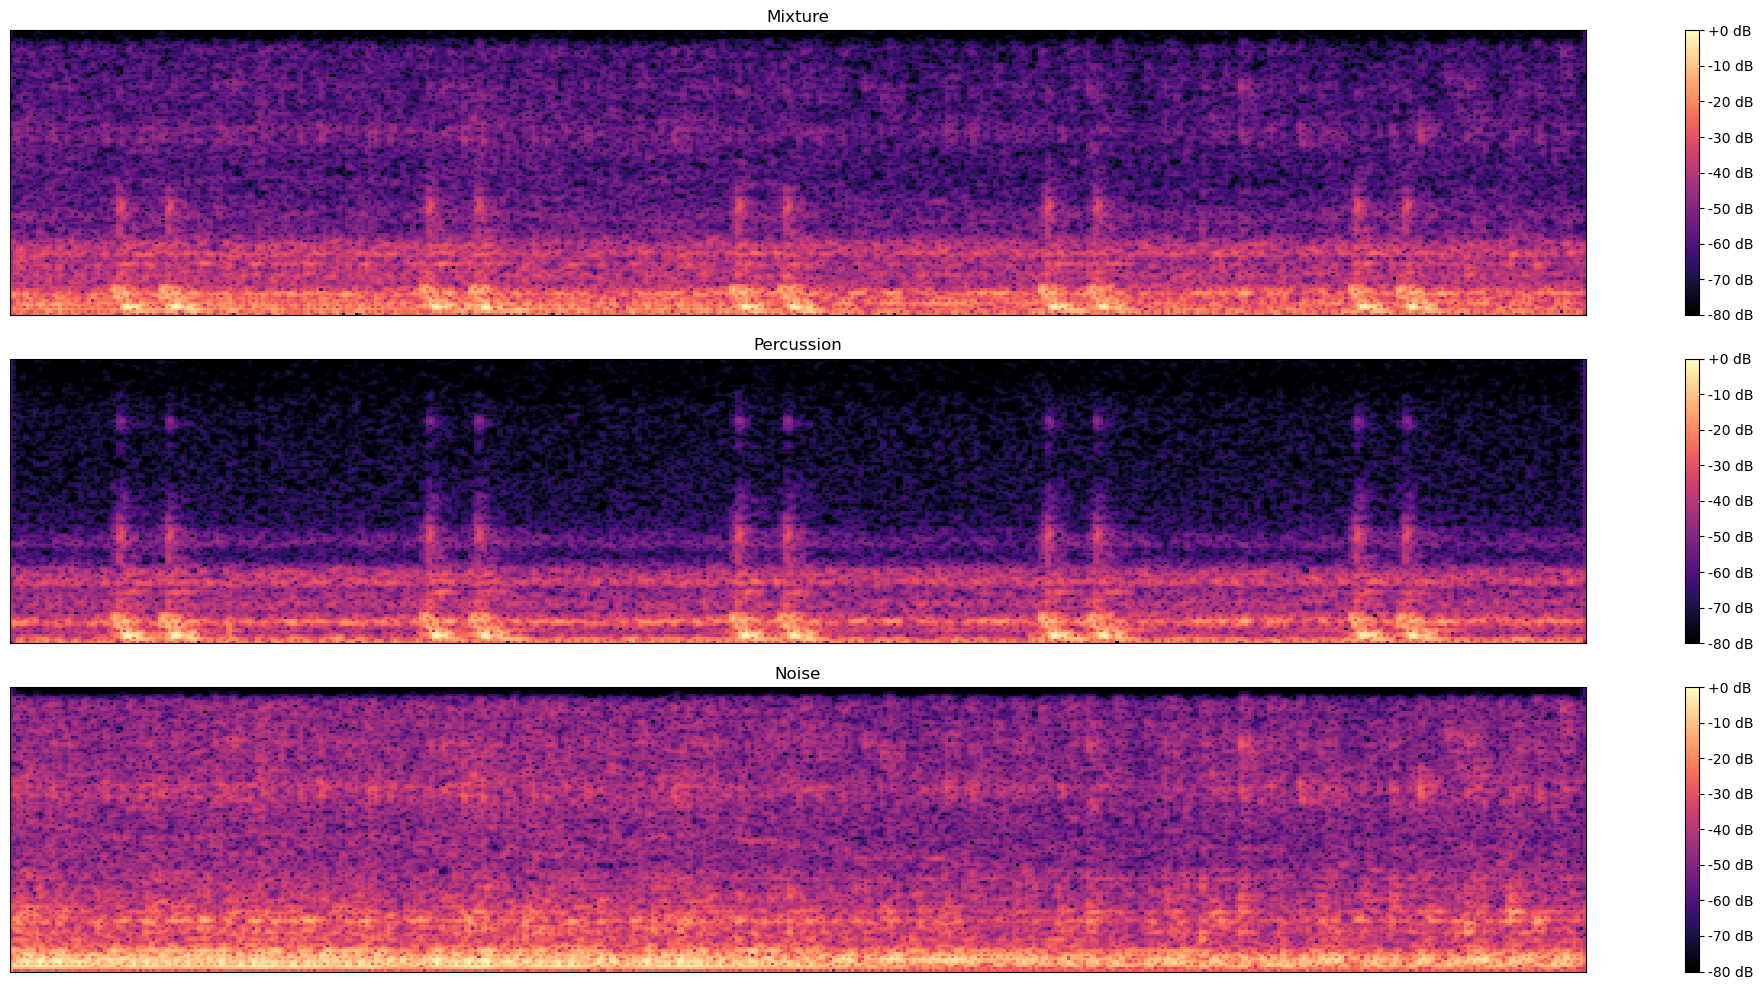

In [ ]:
# randomly select an index
i = random.randint(0, len(data['mixture_stft']) - 1)

# plot the mixture, percussion
mixture_stft = data['mixture_stft'][i]
percussion_stft = data['percussion_stft'][i]
noise_stft = data['noise_stft'][i]

# Convert the mixture to numpy
mixture_stft = mixture_stft.cpu().detach().numpy()

# Convert the target to numpy
percussion_stft = percussion_stft.cpu().detach().numpy()

# Convert the noise to numpy
noise_stft = noise_stft.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(mixture_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(percussion_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.title("Noise")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(noise_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# Define the model

# Evaluation metrics will be : signal-to-distortion ratio improvement SDRi and signal-to-distortion ratio improvement.
# activate torch cudnn
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


class SeparationModel(nn.Module):
    def __init__(self):
        super(SeparationModel, self).__init__()
        """
        Define the model architecture
            It's a resunet model
            The input will be the mixture stft the encoder decoder will process the magnitude spectrogram
            3 encoder blocks 2 bottleneck blocks and 3 decoder blocks.

            In each encoder block, the spectrogram is downsampled into a bottleneck feature using 4 residual convolutional blocks,
            while each decoder block utilizes 4 residual deconvolutional blocks to upsample the feature and obtain the separation components.
            A skip connection is established between each encoder block and the corresponding decoder block, operating at the same downsampling/upsampling rate.
            The residual block consists of 2 CNN layers, 2 batch normalization layers, and 2 Leaky-ReLU activation layers.
            Furthermore, we introduce an additional residual shortcut connecting the input and output of each residual block.
            The ResUNet model inputs the complex spectrogram X and outputs the magnitude mask |M| and the phase residual ∠M conditioned on the text embedding eq.
            |M| controls how much the magnitude of |X| should be scaled, and the angle ∠M controls how much the angle of ∠X should be rotated.
            The separated complex spectrogram can be obtained by multiplying the STFT of the mixture and the predicted magnitude mask |M| and phase residual ∠X:
            Y = |M| ⊙ |X|exp(j(∠X + ∠M)), where ⊙ denotes Hadamard product.
        """

        self.encoder1 = nn.Sequential(
            # 2 channels for the magnitude and phase
            nn.Conv2d(2, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # to get the mask
        )

    def forward(self, x):

        # print(f'input shape: {x.shape}')

        # add the channel dimension torch.size([16, 1, 129, 489])
        x = x.unsqueeze(1)
        # we want  torch.size([16, 2, 129, 489]) first channel is the magnitude and the second is the phase
        # so when we do output = model(mixture_stft) we get the magnitude and phase of the output in
        x = torch.cat((torch.abs(x), torch.angle(x)), dim=1)
        # print(f'input shape after cat: {x.shape}')
        # print(x)
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)

        # Bottleneck
        b = self.bottleneck(x3)

        # Decoder
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)

        # Output
        out = self.output(d3)

        # out shape: torch.Size([4, 1, 136, 496]) our input is torch.Size([4, 1, 129, 489]) so we have to resize the output to match the input
        # print(f'out shape after Conv2d from output: {out.shape}')

        # resize the output to match the input
        out = F.interpolate(out, size=(129, 489),
                            mode='bilinear', align_corners=False)
        # print(f'out shape after interpolate: {out.shape}')
        return out

In [ ]:
# define the metrics


# def calculate_sdr(target, prediction):
#     # Calculate the signal-to-distortion ratio
#     target_power = torch.sum(target**2)
#     error_power = torch.sum((target - prediction)**2)
#     sdr = 10 * torch.log10(target_power / error_power)
#     return sdr

def calculate_sdr_improvement(target, prediction, mixture):
    """
        Compute the signal-to-distortion ratio improvement

    Args:
        target (_type_): true percussion signal
        prediction (_type_): predicted percussion signal
        mixture (_type_): mixture of the percussion and noise signals

    Returns:
        _type_: signal-to-distortion ratio improvement
    """
    # Calculate the signal-to-distortion ratio improvement
    target_power = torch.sum(target**2)  # target is the percussion
    error_power = torch.sum((target - prediction)**2)
    mixture_power = torch.sum(mixture**2)
    sdr = 10 * torch.log10(target_power / error_power)
    sdr_mixture = 10 * torch.log10(target_power / mixture_power)
    sdr_i = sdr - sdr_mixture
    return sdr_i


# define the loss function


def loss_function(prediction, target):
    # spectral loss
    # log magnitude spectrogram loss
    # target is the percussion target_stft we take the magnitude of the target hence the abs
    # prediction is the predicted percussion stft
    # ||log(abs(target) + 1e-9) - log(abs(prediction) + 1e-9)||_L1, L1 norm

    # Calculate the log magnitude spectrogram loss

    target_stft = torch.log(torch.abs(target) + 1e-9)
    prediction_stft = torch.log(torch.abs(prediction) + 1e-9)
    loss = F.l1_loss(target_stft, prediction_stft)

    return loss

In [ ]:
DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio_engine_idling"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
# load the best model (least loss)

model.load_state_dict(torch.load(
    "best_model.6_with_val_loss1.2521952390670776.pth", weights_only=True))

model.eval()

criterion = loss_function

In [ ]:
# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Mixtures names dataframe to store the mix names
mixtures_names = []

# Disable gradient computation
with torch.no_grad():

    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        mixture_true = data['mixture_audio'].to(device)
        mixture_name = data['mixture_name']
        mixture_stft = data['mixture_stft'].to(device)

        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)
        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        # for i in range(len(predicted_stft)):  # 16
        #     # take the magnitude and phase
        #     predicted_mag = torch.abs(predicted_stft)
        #     predicted_phase = torch.angle(predicted_stft)

        #     # Convert the output to audio
        #     predicted_audio = audio_from_spectrogram(
        #         predicted_mag, predicted_phase)
        #     # print(f'predicted_audio shape: {predicted_audio.shape}') 16

        #     # Calculate the signal-to-distortion ratio improvement
        #     sdr_i = calculate_sdr_improvement(
        #         percussion_true, predicted_audio, mixture_true)
        #     SDRi_list.append(sdr_i)

        #     predicted_audio_path = os.path.join(
        #         DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted.wav")
        #     for i in range(len(predicted_audio)):
        #         sf.write(predicted_audio_path, predicted_audio[i].cpu(), 7812)

        # take the magnitude and phase
        predicted_mag = torch.abs(predicted_stft)
        predicted_phase = torch.angle(predicted_stft)

        # Convert the output to audio
        predicted_audio = audio_from_spectrogram(
            predicted_mag, predicted_phase)

        # Calculate the signal-to-distortion ratio improvement
        sdr_i = calculate_sdr_improvement(
            percussion_true, predicted_audio, mixture_true)
        SDRi_list.append(sdr_i)

        # save the predicted audio with the name of the true percussion audio
        for k in range(len(predicted_audio)):
            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[k].split('.wav')[0]}_mix{mixture_name[k].split('.wav')[1]}_predicted.wav")
            sf.write(predicted_audio_path, predicted_audio[k].cpu(), 7812)

        # Update the mixture names
        mixtures_names.extend(mixture_name)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")


# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

# Print the signal-to-distortion ratio improvement list
print(f"SDRi list: {SDRi_list}")

Testing Loss: 1.3487: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

Test Loss: 1.3487
Average SDRi: 9.984704971313477
SDRi list: [tensor(10.6774, device='cuda:0'), tensor(11.1022, device='cuda:0'), tensor(10.2481, device='cuda:0'), tensor(10.1491, device='cuda:0'), tensor(9.2566, device='cuda:0'), tensor(8.7227, device='cuda:0'), tensor(10.0409, device='cuda:0'), tensor(10.7153, device='cuda:0'), tensor(10.0663, device='cuda:0'), tensor(9.2949, device='cuda:0'), tensor(9.4306, device='cuda:0'), tensor(8.9631, device='cuda:0'), tensor(11.1340, device='cuda:0')]


In [ ]:
df = pd.DataFrame(mixtures_names)

df['percussion name'] = df[0].apply(
    lambda x: x.split('.wav')[0])

# rename first column to mix name
df.rename(columns={0: 'mix name'}, inplace=True)

# get the noise
df['noise name'] = df['mix name'].apply(
    lambda x: x.split('.wav_')[1])

df

mix name           percussion name  \
0    data_2024_02_14-14_47_39.wav_186938-5-0-0.wav  data_2024_02_14-14_47_39   
1    hps_2024_03_13-15_56_03.wav_113202-5-0-12.wav   hps_2024_03_13-15_56_03   
2     hps_2024_03_05-15_52_20.wav_113203-5-2-0.wav   hps_2024_03_05-15_52_20   
3     hps_2024_03_05-15_54_09.wav_201652-5-5-2.wav   hps_2024_03_05-15_54_09   
4    data_2024_03_13-11_07_32.wav_144007-5-1-1.wav  data_2024_03_13-11_07_32   
..                                             ...                       ...   
189  data_2024_02_12-14_07_09.wav_113203-5-0-7.wav  data_2024_02_12-14_07_09   
190    hps_2024_03_05-15_34_15.wav_62567-5-0-9.wav   hps_2024_03_05-15_34_15   
191   hps_2024_02_26-09_30_42.wav_103258-5-0-7.wav   hps_2024_02_26-09_30_42   
192  data_2024_02_26-09_26_36.wav_113203-5-0-3.wav  data_2024_02_26-09_26_36   
193  data_2024_03_13-16_06_22.wav_166101-5-2-0.wav  data_2024_03_13-16_06_22   

            noise name  
0     186938-5-0-0.wav  
1    113202-5-0-12.wav  
2     113203-5-2-0.wav  
3     201652-5-5-2.wav  
4     144007-5-1-1.wav  
..                 ...  
189   113203-5-0-7.wav  
190    62567-5-0-9.wav  
191   103258-5-0-7.wav  
192   113203-5-0-3.wav  
193   166101-5-2-0.wav  

[194 rows x 3 columns]

In [ ]:
# create new column with the predicted files we saved
df['predicted name'] = df['percussion name'].apply(
    lambda x: f"{x}_mix{df[df['percussion name'] == x]['mix name'].values[0].split('.wav')[1]}_predicted.wav")

# merge the metadata file with the df file
# for the corresponding noise file we add it's fold and class

for noise_file in df['noise name']:
    row = metadata[metadata['noise_file'] == noise_file]
    df.loc[df['noise name'] == noise_file, 'fold'] = row['fold'].values[0]
    df.loc[df['noise name'] == noise_file,
           'noise_class'] = row['noise_class'].values[0]

df['fold'] = df['fold'].astype(int)
df

mix name           percussion name  \
0    data_2024_02_14-14_47_39.wav_186938-5-0-0.wav  data_2024_02_14-14_47_39   
1    hps_2024_03_13-15_56_03.wav_113202-5-0-12.wav   hps_2024_03_13-15_56_03   
2     hps_2024_03_05-15_52_20.wav_113203-5-2-0.wav   hps_2024_03_05-15_52_20   
3     hps_2024_03_05-15_54_09.wav_201652-5-5-2.wav   hps_2024_03_05-15_54_09   
4    data_2024_03_13-11_07_32.wav_144007-5-1-1.wav  data_2024_03_13-11_07_32   
..                                             ...                       ...   
189  data_2024_02_12-14_07_09.wav_113203-5-0-7.wav  data_2024_02_12-14_07_09   
190    hps_2024_03_05-15_34_15.wav_62567-5-0-9.wav   hps_2024_03_05-15_34_15   
191   hps_2024_02_26-09_30_42.wav_103258-5-0-7.wav   hps_2024_02_26-09_30_42   
192  data_2024_02_26-09_26_36.wav_113203-5-0-3.wav  data_2024_02_26-09_26_36   
193  data_2024_03_13-16_06_22.wav_166101-5-2-0.wav  data_2024_03_13-16_06_22   

            noise name                                     predicted name  \
0     186938-5-0-0.wav  data_2024_02_14-14_47_39_mix_186938-5-0-0_pred...   
1    113202-5-0-12.wav  hps_2024_03_13-15_56_03_mix_113202-5-0-12_pred...   
2     113203-5-2-0.wav  hps_2024_03_05-15_52_20_mix_113203-5-2-0_predi...   
3     201652-5-5-2.wav  hps_2024_03_05-15_54_09_mix_201652-5-5-2_predi...   
4     144007-5-1-1.wav  data_2024_03_13-11_07_32_mix_144007-5-1-1_pred...   
..                 ...                                                ...   
189   113203-5-0-7.wav  data_2024_02_12-14_07_09_mix_113202-5-0-27_pre...   
190    62567-5-0-9.wav  hps_2024_03_05-15_34_15_mix_62567-5-0-8_predic...   
191   103258-5-0-7.wav  hps_2024_02_26-09_30_42_mix_103258-5-0-7_predi...   
192   113203-5-0-3.wav  data_2024_02_26-09_26_36_mix_113203-5-0-3_pred...   
193   166101-5-2-0.wav  data_2024_03_13-16_06_22_mix_166101-5-2-0_pred...   

     fold    noise_class  
0       4  engine_idling  
1       8  engine_idling  
2       8  engine_idling  
3       2  engine_idling  
4       4  engine_idling  
..    ...            ...  
189     8  engine_idling  
190     9  engine_idling  
191     1  engine_idling  
192     8  engine_idling  
193     3  engine_idling  

[194 rows x 6 columns]

In [ ]:
# save this df in the corresponding precicted folder class

df.to_csv(os.path.join(DATASET_PREDICTED_AUDIO_PATH,
          "metadata_pred_engine_idling.csv"), index=False)

In [ ]:
# Define the dataset


class TestSeparationDataset(Dataset):
    def __init__(self, metadata_file):

        self.metadata = metadata_file

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # Load the predicted audio
        predicted_audio = librosa.load(os.path.join(
            DATASET_PREDICTED_AUDIO_PATH, row['predicted name']), sr=7812)[0]

        print(f'file name pred : {row["predicted name"]}')

        # Load the true percussion audio
        percussion_audio = pad_audio_center(os.path.join(
            DATASET_PERCUSSION_PATH, row['percussion name'] + '.wav'))
        print(f'path perc: {os.path.join(
            DATASET_PERCUSSION_PATH, row["percussion name"] + ".wav")}')
        print(f'file name true perc : {row["percussion name"]}')

        # Load the mixture audio
        # mixture_audio = librosa.load(os.path.join(
        #     DATASET_MIX_AUDIO_PATH, row['mix name'] + '.wav'), sr=7812)[0]

        # Load the noise audio
        noise_audio = pad_audio_center(os.path.join(
            DATASET_NOISE_PATH, f"fold{row['fold']}", row['noise name']))

        print(f'path noise: {os.path.join(
            DATASET_NOISE_PATH, f"fold{row["fold"]}", row["noise name"])}')
        print(f'noise class: {row["noise_class"]}')

        # create mixture audio
        mixture_audio, _ = create_mixture(
            percussion_audio, noise_audio, k=0.8)

        percussion_audio /= np.max(np.abs(percussion_audio))
        noise_audio /= np.max(np.abs(noise_audio))

        return {
            'predicted audio': predicted_audio,
            'percussion audio': percussion_audio,
            'mixture audio': mixture_audio,
            'noise audio': noise_audio
        }

In [ ]:
# Create the dataset
test_separation_dataset = TestSeparationDataset(
    metadata_file=df)

# Create the data loader
test_separation_loader = DataLoader(
    test_separation_dataset, batch_size=16, shuffle=True)

# Plot the predicted and true percussion signals along their spectrograms
data = next(iter(test_separation_loader))

file name pred : hps_2024_02_28-08_30_47_mix_144007-5-0-9_predicted.wav
path perc: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\hps_2024_02_28-08_30_47.wav
file name true perc : hps_2024_02_28-08_30_47
path noise: C:\Users\jejep\Desktop\STAGE\dataset\fold4\144007-5-0-9.wav
noise class: engine_idling
file name pred : hps_2024_03_13-16_09_07_mix_144007-5-0-0_predicted.wav
path perc: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\hps_2024_03_13-16_09_07.wav
file name true perc : hps_2024_03_13-16_09_07
path noise: C:\Users\jejep\Desktop\STAGE\dataset\fold4\144007-5-0-0.wav
noise class: engine_idling
file name pred : hps_2024_02_26-09_35_40_mix_176787-5-0-19_predicted.wav
path perc: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\hps_2024_02_26-09_35_40.wav
file name true perc : hps_2024_02_26-09_35_40
path noise: C:\Users\jejep\Desktop\STAGE\dataset\fold1\176787-5-0-19.wav
noise class: engine_idling
file name pred : data_2024_03_13-16_06_28_mix_128160-5-0-3_predicted.wav
path perc: C:\Users\je

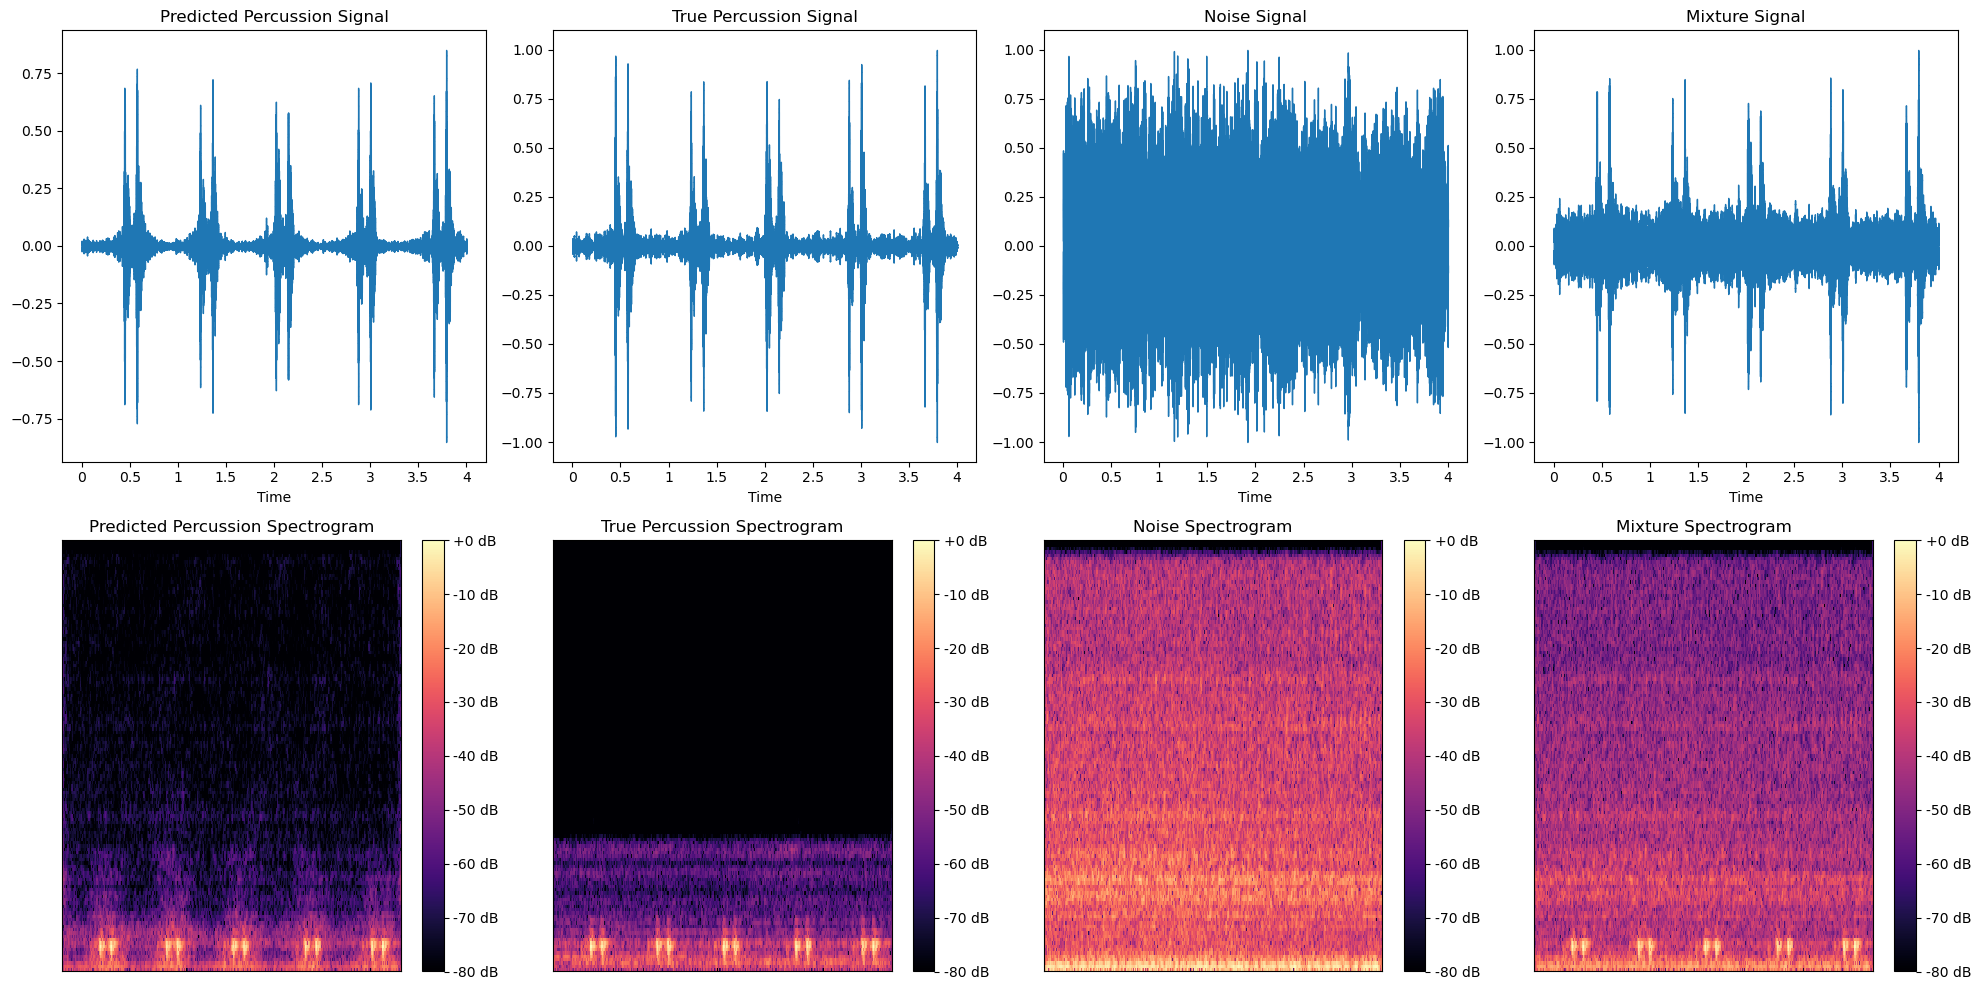

In [ ]:
# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert predicted audio to numpy
predicted_audio = data['predicted audio'][i]
predicted_audio = predicted_audio.cpu().detach().numpy()

# convert true percussion audio to numpy
true_percussion_audio = data['percussion audio'][i]
true_percussion_audio = true_percussion_audio.cpu().detach().numpy()

# convert audio to numpy
noise_audio = data['noise audio'][i]
noise_audio = noise_audio.cpu().detach().numpy()

# convert mixture audio to numpy
mixture_audio = data['mixture audio'][i]
mixture_audio = mixture_audio.cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.title("Predicted Percussion Signal")
librosa.display.waveshow(predicted_audio, sr=7812)

plt.subplot(2, 4, 2)
plt.title("True Percussion Signal")
librosa.display.waveshow(true_percussion_audio, sr=7812)

plt.subplot(2, 4, 3)
plt.title("Noise Signal")
librosa.display.waveshow(noise_audio, sr=7812)

plt.subplot(2, 4, 4)
plt.title("Mixture Signal")
librosa.display.waveshow(mixture_audio, sr=7812)

# Plot the predicted and true percussion spectrograms
plt.subplot(2, 4, 5)
plt.title("Predicted Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(predicted_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 6)
plt.title("True Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(true_percussion_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 7)
plt.title("Noise Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(noise_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 8)
plt.title("Mixture Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

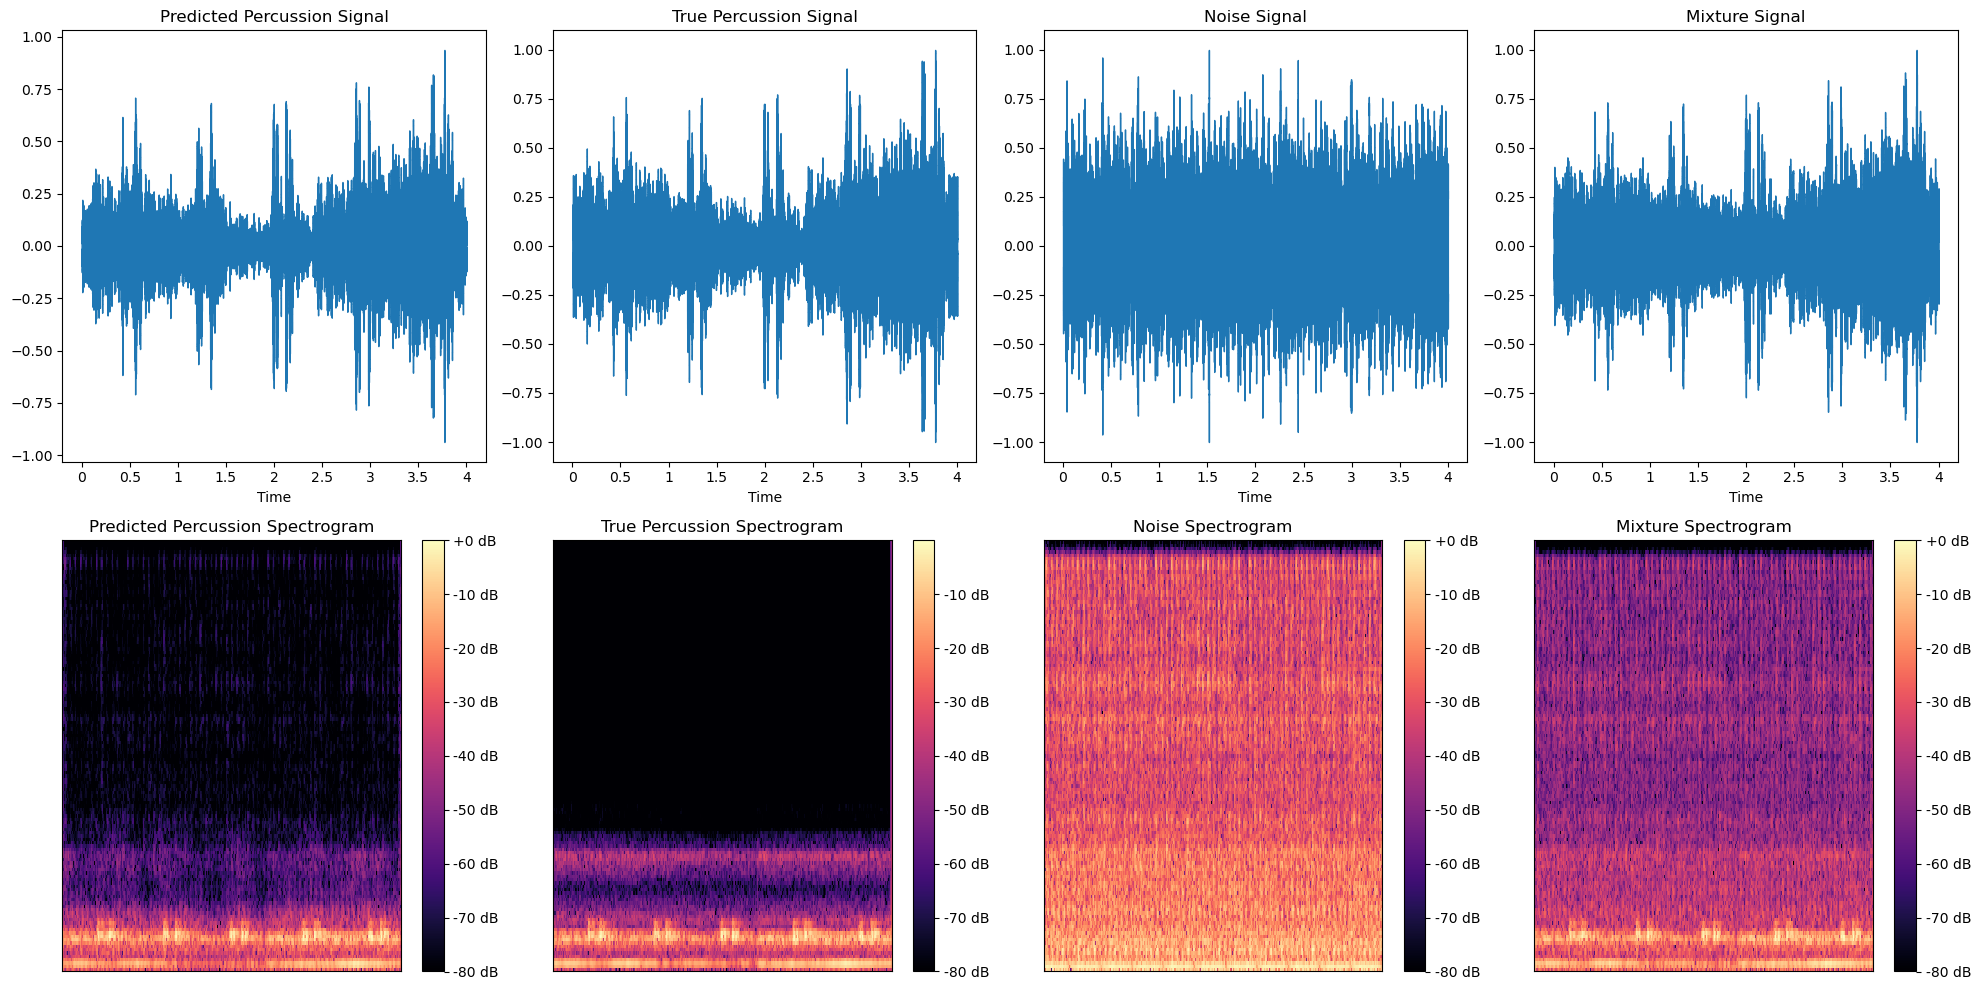

In [ ]:
# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert predicted audio to numpy
predicted_audio = data['predicted audio'][i]
predicted_audio = predicted_audio.cpu().detach().numpy()

# convert true percussion audio to numpy
true_percussion_audio = data['percussion audio'][i]
true_percussion_audio = true_percussion_audio.cpu().detach().numpy()

# convert audio to numpy
noise_audio = data['noise audio'][i]
noise_audio = noise_audio.cpu().detach().numpy()

# convert mixture audio to numpy
mixture_audio = data['mixture audio'][i]
mixture_audio = mixture_audio.cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.title("Predicted Percussion Signal")
librosa.display.waveshow(predicted_audio, sr=7812)

plt.subplot(2, 4, 2)
plt.title("True Percussion Signal")
librosa.display.waveshow(true_percussion_audio, sr=7812)

plt.subplot(2, 4, 3)
plt.title("Noise Signal")
librosa.display.waveshow(noise_audio, sr=7812)

plt.subplot(2, 4, 4)
plt.title("Mixture Signal")
librosa.display.waveshow(mixture_audio, sr=7812)

# Plot the predicted and true percussion spectrograms
plt.subplot(2, 4, 5)
plt.title("Predicted Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(predicted_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 6)
plt.title("True Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(true_percussion_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 7)
plt.title("Noise Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(noise_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 8)
plt.title("Mixture Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# Define the dataset


class TestSeparationDataset(Dataset):
    def __init__(self, metadata_file):

        self.metadata = metadata_file

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # Load the predicted audio
        predicted_audio_path = os.path.join(
            DATASET_PREDICTED_AUDIO_PATH, row['predicted name'])
        predicted_audio = librosa.load(predicted_audio_path, sr=7812)[0]

        # Load the true percussion audio
        percussion_path = os.path.join(
            DATASET_PERCUSSION_PATH, row['percussion name'] + '.wav')
        percussion_audio = pad_audio_center(percussion_path)

        # Load the mixture audio
        # mixture_audio = librosa.load(os.path.join(
        #     DATASET_MIX_AUDIO_PATH, row['mix name'] + '.wav'), sr=7812)[0]

        # Load the noise audio
        noise_path = os.path.join(
            DATASET_NOISE_PATH, f"fold{row['fold']}", row['noise name'])
        noise_audio = pad_audio_center(noise_path)

        # create mixture audio
        mixture_audio, _ = create_mixture(
            percussion_audio, noise_audio, k=0.8)

        percussion_audio /= np.max(np.abs(percussion_audio))
        noise_audio /= np.max(np.abs(noise_audio))

        return {
            'path pred': predicted_audio_path,
            'predicted audio': predicted_audio,

            'path true': percussion_path,
            'percussion audio': percussion_audio,

            'path mix': row['mix name'],
            'mixture audio': mixture_audio,

            'path noise': noise_path,
            'noise audio': noise_audio
        }

In [ ]:
# Create the dataset
test_separation_dataset = TestSeparationDataset(
    metadata_file=df)

# Create the data loader
test_separation_loader = DataLoader(
    test_separation_dataset, batch_size=16, shuffle=True)

# Plot the predicted and true percussion signals along their spectrograms
data = next(iter(test_separation_loader))

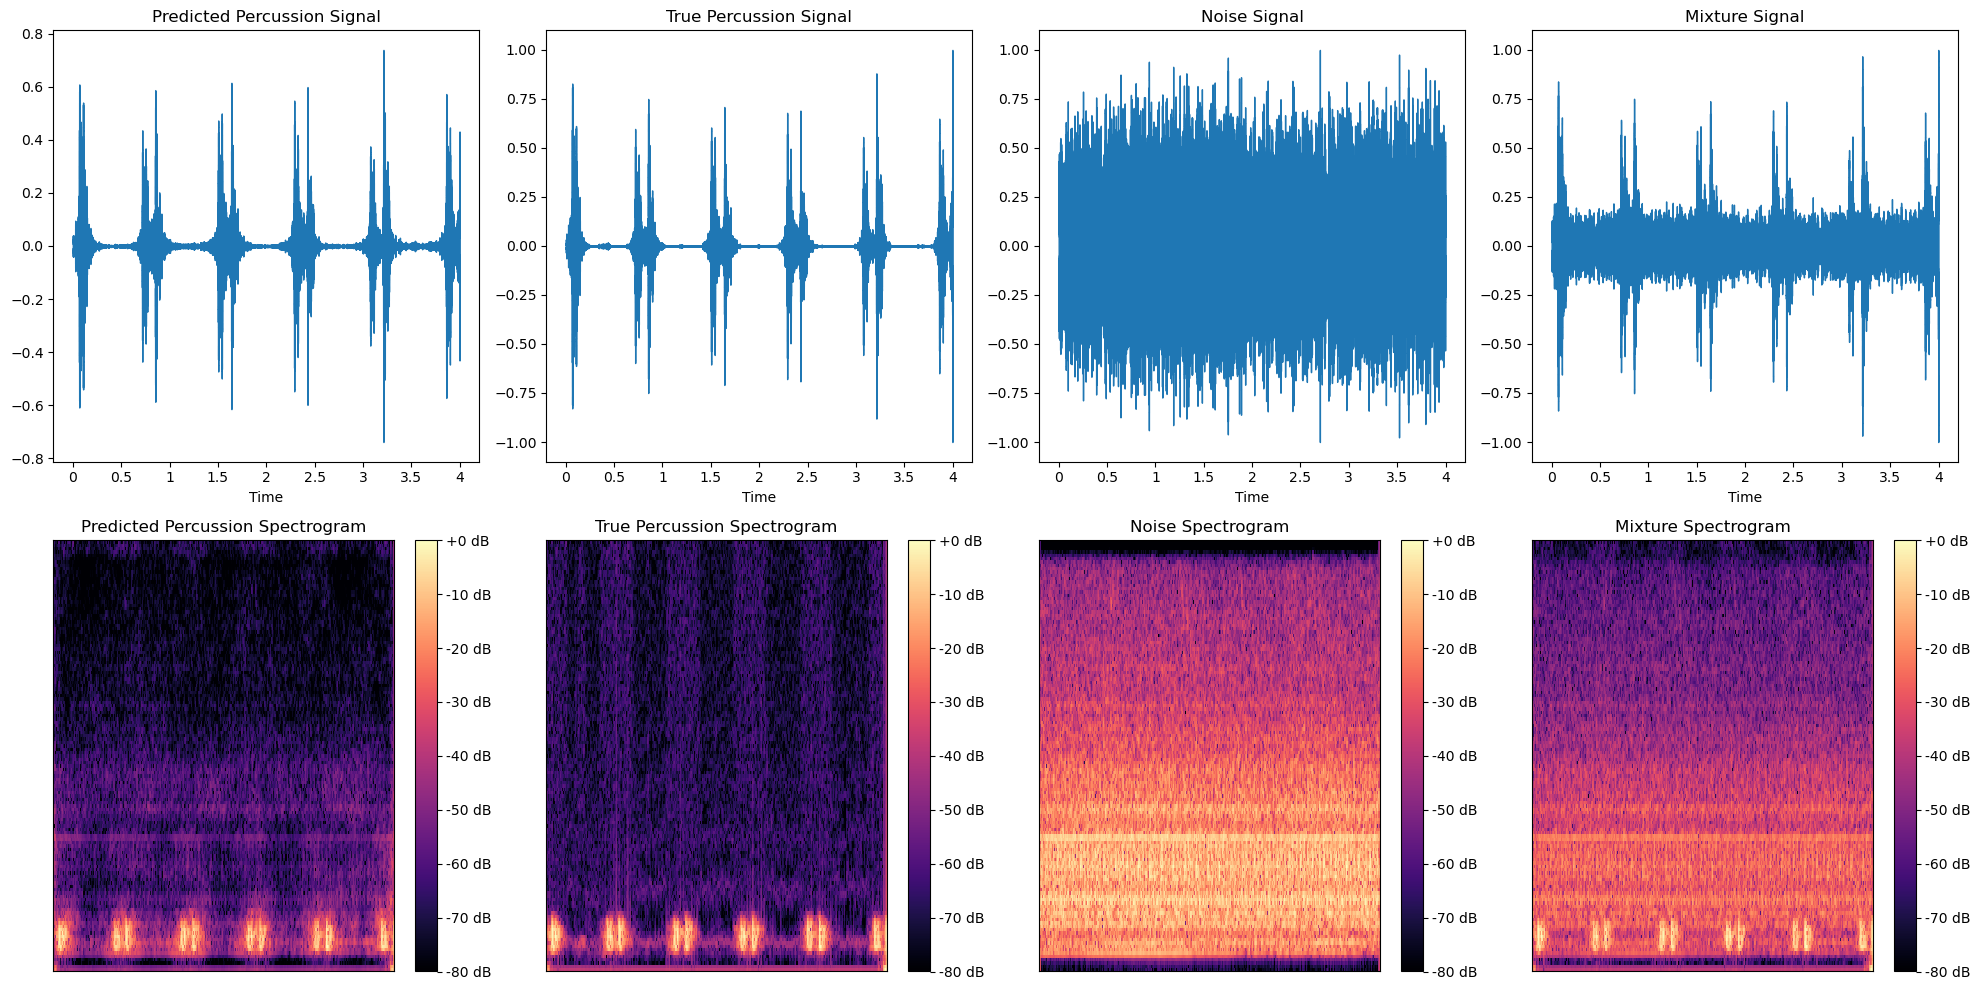

In [ ]:
# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert predicted audio to numpy
predicted_audio = data['predicted audio'][i]
predicted_audio = predicted_audio.cpu().detach().numpy()

# convert true percussion audio to numpy
true_percussion_audio = data['percussion audio'][i]
true_percussion_audio = true_percussion_audio.cpu().detach().numpy()

# convert audio to numpy
noise_audio = data['noise audio'][i]
noise_audio = noise_audio.cpu().detach().numpy()

# convert mixture audio to numpy
mixture_audio = data['mixture audio'][i]
mixture_audio = mixture_audio.cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.title("Predicted Percussion Signal")
librosa.display.waveshow(predicted_audio, sr=7812)

plt.subplot(2, 4, 2)
plt.title("True Percussion Signal")
librosa.display.waveshow(true_percussion_audio, sr=7812)

plt.subplot(2, 4, 3)
plt.title("Noise Signal")
librosa.display.waveshow(noise_audio, sr=7812)

plt.subplot(2, 4, 4)
plt.title("Mixture Signal")
librosa.display.waveshow(mixture_audio, sr=7812)

# Plot the predicted and true percussion spectrograms
plt.subplot(2, 4, 5)
plt.title("Predicted Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(predicted_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 6)
plt.title("True Percussion Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(true_percussion_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 7)
plt.title("Noise Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(noise_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 4, 8)
plt.title("Mixture Spectrogram")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(
    librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Print the names of all the files shown

In [ ]:
# %%

" ai for source separation of percussions in urban sounds"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import random
import argparse
import pandas as pd
from tqdm import tqdm
# We have 7358 sounds of differents classes (dog bark, drilling, jackhammer, siren, children_playing, engine idling, air conditioner, car horn) with a duration of maximum 4 seconds some are shorter
# 387 files of the percussions class that we want to separate from the others or "hear" better

n_fft = 256
hop_length = n_fft // 4

In [ ]:
# %%

# where to find the noise
DATASET_NOISE_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\dataset"

metadata_noise = os.path.join(DATASET_NOISE_PATH, "UrbanSound8k.csv")
metadata_noise = pd.read_csv(metadata_noise)
print(metadata_noise['class'].value_counts())

# class
# dog_bark            1000
# children_playing    1000
# air_conditioner     1000
# engine_idling       1000
# jackhammer          1000
# drilling            1000
# siren                929
# car_horn             429
# Name: count, dtype: int64

DATASET_PERCUSSION_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\J.Palmilha\\data"
metadata_perc = os.path.join(DATASET_PERCUSSION_PATH, "metadata.csv")
metadata_perc = pd.read_csv(metadata_perc)

metadata_perc.value_counts()

# Example dataframe for noise classes
noise_data = {
    'class': ['dog_bark', 'children_playing', 'air_conditioner', 'engine_idling',
              'jackhammer', 'drilling', 'siren', 'car_horn'],
    'count': [1000, 1000, 1000, 1000, 1000, 1000, 929, 429]
}
df = pd.DataFrame(noise_data)

# Example paths to noise files (adjust paths according to your setup)
noise_folder = DATASET_NOISE_PATH  # path to the folder containing the noise files

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64


In [ ]:
# %%

# Function to create mixture


def create_mixture(percussion_audio, noise_audio, k=0.8):

    percussion_audio /= np.max(np.abs(percussion_audio))
    noise_audio /= np.max(np.abs(noise_audio))

    # Mix audio files
    mixture_audio = k*percussion_audio + (1-k)*noise_audio

    # Normalize mixture
    mixture_audio /= np.max(np.abs(mixture_audio))

    # Calculate stft
    stft = librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)

    return mixture_audio, stft


def get_stft(audio):

    # Normalize audio
    audio /= np.max(np.abs(audio))

    # Calculate stft
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    return stft


def audio_from_spectrogram(mag, phase):
    stft = mag * torch.exp(1j * phase)
    # print(f'stft device', stft.device)
    # audio = librosa.istft(stft, hop_length=hop_length)
    audio = torch.istft(stft, n_fft=n_fft, hop_length=hop_length,
                        length=4 * 7812, window=torch.hann_window(n_fft, device='cuda'))
    return audio

# calculate error reconstruction and original


def calculate_error(original, reconstruction):
    error = torch.abs(original - reconstruction).mean()  # mean absolute
    return error

In [ ]:
# %%

# Total number of percussion files
percussion_count = 387

# Calculate total number of noise files
total_noise_files = df['count'].sum()

# Calculate proportions for each noise class
df['proportion'] = df['count'] / total_noise_files

# every percussion files will get 40 noise files 5 from each class
# this will give us a total number of 387 * 24 = 9288 noise files
# Number of noise files to select for each percussion file
noise_files_per_percussion = 40

# we will save the informations of all the noised used for each percussion file
# save the informations in a csv file : percussion_file, noise_file, noise_class, mixture_file


def pad_audio_center(audio_path):

    # Load audio files
    audio, _ = librosa.load(path=audio_path, sr=7812)

    # Pad audio to have length of 4 seconds
    audio_len = len(audio)
    target_len = 4 * 7812  # 4 seconds at 7812 Hz
    pad_len = target_len - audio_len

    if pad_len > 0:
        pad_left = pad_len // 2
        pad_right = pad_len - pad_left
        audio = np.pad(audio, (pad_left, pad_right), 'constant')
    else:
        audio = audio[:target_len]

    return audio

In [ ]:
# %%

# Create a folder to save mixture audio
DATASET_MIX_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_audio"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_AUDIO_PATH):
    os.makedirs(DATASET_MIX_AUDIO_PATH)

DATASET_MIX_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_STFT_PATH):
    os.makedirs(DATASET_MIX_STFT_PATH)

# Create a folder to save percussion stft
DATASET_PERCUSSION_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\percussion_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_PERCUSSION_STFT_PATH):
    os.makedirs(DATASET_PERCUSSION_STFT_PATH)

# Create a folder to save noise stft
DATASET_NOISE_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\noise_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_NOISE_STFT_PATH):
    os.makedirs(DATASET_NOISE_STFT_PATH)

In [ ]:
# %%

# Define the dataset class


class MixtureDataset(Dataset):
    # noise class is a string maybe
    def __init__(self, metadata_file, transform=None, noise_class=None):
        self.metadata = metadata_file
        # since we have multiple classes of noise we can choose one to train the model... we can also train the model with all the classes
        # we can use it to load only the noise files of a specific class
        self.noise_class = noise_class
        self.transform = transform

    def __len__(self):
        # get the row with only the noise class we want
        if self.noise_class:
            return len(self.metadata[self.metadata['noise_class'] == self.noise_class])

    def __getitem__(self, idx):
        # get the row with only the noise class we want
        if self.noise_class:
            row = self.metadata[self.metadata['noise_class']
                                == self.noise_class].iloc[idx]

            # # Load mixture audio and percussion audio
            # mixture_audio = librosa.load(os.path.join(
            #     DATASET_MIX_AUDIO_PATH, f"{row['mix_file']}.wav"), sr=7812)[0]

            # make mixture on the fly :

            percussion_audio = pad_audio_center(os.path.join(
                DATASET_PERCUSSION_PATH, row['percussion_file']))
            noise_audio = pad_audio_center(os.path.join(
                DATASET_NOISE_PATH, f"fold{row['fold']}", row['noise_file']))

            mixture_audio, mixture_stft = create_mixture(
                percussion_audio, noise_audio, k=0.8)
            mixture_stft = torch.tensor(
                mixture_stft, requires_grad=True, dtype=torch.complex64)

            # Load mixture stft
            # mixture_stft = np.load(os.path.join(
            #     DATASET_MIX_STFT_PATH, f"{row['mix_file']}.npy"))
            # mixture_stft = torch.tensor(
            #     mixture_stft, requires_grad=True, dtype=torch.complex64)

            # Load noise stft
            # noise_stft = np.load(os.path.join(
            #     DATASET_NOISE_STFT_PATH, f"{row['noise_file']}.npy"))
            # noise_stft = torch.tensor(
            #     noise_stft, requires_grad=True, dtype=torch.complex64)

            # Load percussion stft
            # percussion_stft = np.load(os.path.join(
            #     DATASET_PERCUSSION_STFT_PATH, f"{row['percussion_file']}.npy"))
            percussion_stft = get_stft(percussion_audio)
            percussion_stft = torch.tensor(
                percussion_stft, requires_grad=True, dtype=torch.complex64)

            noise_stft = get_stft(noise_audio)
            noise_stft = torch.tensor(
                noise_stft, requires_grad=True, dtype=torch.complex64)

            # if self.transform:
            #     mix_mag, mix_phase = transform(mixture_stft)
            #     noise_mag, noise_phase = transform(noise_stft)
            #     percussion_mag, percussion_phase = transform(percussion_stft)

            #     return {
            #         'mixture_audio': mixture_audio,
            #         'mixture_stft': mixture_stft,
            #         'mixture_mag': mix_mag,
            #         'mixture_phase': mix_phase,

            #         'noise_mag': noise_mag,
            #         'noise_phase': noise_phase,

            #         'percussion_audio': percussion_audio,
            #         'percussion_mag': percussion_mag,
            #         'percussion_phase': percussion_phase,
            #         'percussion_stft': percussion_stft
            #     }

            percussion_audio /= np.max(np.abs(percussion_audio))
            noise_audio /= np.max(np.abs(noise_audio))

            return {
                'mixture_name': row['mix_file'],
                'mixture_audio': mixture_audio,
                'mixture_stft': mixture_stft,

                # 'noise_stft': noise_stft,
                'percussion_name': row['percussion_file'],
                'percussion_audio': percussion_audio,
                'percussion_stft': percussion_stft,

                'noise_name': row['noise_file'],
                'noise_class': row['noise_class'],
                'noise_audio': noise_audio,
                'noise_stft': noise_stft
            }

# transform function, get the magnitude and phase of the stft


def transform(stft): return (torch.abs(stft), torch.angle(stft))

In [ ]:
# %%

# Define the model

# Evaluation metrics will be : signal-to-distortion ratio improvement SDRi and signal-to-distortion ratio improvement.
# activate torch cudnn
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


class SeparationModel(nn.Module):
    def __init__(self):
        super(SeparationModel, self).__init__()
        """
        Define the model architecture
            It's a resunet model
            The input will be the mixture stft the encoder decoder will process the magnitude spectrogram
            3 encoder blocks 2 bottleneck blocks and 3 decoder blocks.

            In each encoder block, the spectrogram is downsampled into a bottleneck feature using 4 residual convolutional blocks,
            while each decoder block utilizes 4 residual deconvolutional blocks to upsample the feature and obtain the separation components.
            A skip connection is established between each encoder block and the corresponding decoder block, operating at the same downsampling/upsampling rate.
            The residual block consists of 2 CNN layers, 2 batch normalization layers, and 2 Leaky-ReLU activation layers.
            Furthermore, we introduce an additional residual shortcut connecting the input and output of each residual block.
            The ResUNet model inputs the complex spectrogram X and outputs the magnitude mask |M| and the phase residual ∠M conditioned on the text embedding eq.
            |M| controls how much the magnitude of |X| should be scaled, and the angle ∠M controls how much the angle of ∠X should be rotated.
            The separated complex spectrogram can be obtained by multiplying the STFT of the mixture and the predicted magnitude mask |M| and phase residual ∠X:
            Y = |M| ⊙ |X|exp(j(∠X + ∠M)), where ⊙ denotes Hadamard product.
        """

        self.encoder1 = nn.Sequential(
            # 2 channels for the magnitude and phase
            nn.Conv2d(2, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # to get the mask
        )

    def forward(self, x):

        # print(f'input shape: {x.shape}')

        # add the channel dimension torch.size([16, 1, 129, 489])
        x = x.unsqueeze(1)
        # we want  torch.size([16, 2, 129, 489]) first channel is the magnitude and the second is the phase
        # so when we do output = model(mixture_stft) we get the magnitude and phase of the output in
        x = torch.cat((torch.abs(x), torch.angle(x)), dim=1)
        # print(f'input shape after cat: {x.shape}')
        # print(x)
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)

        # Bottleneck
        b = self.bottleneck(x3)

        # Decoder
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)

        # Output
        out = self.output(d3)

        # out shape: torch.Size([4, 1, 136, 496]) our input is torch.Size([4, 1, 129, 489]) so we have to resize the output to match the input
        # print(f'out shape after Conv2d from output: {out.shape}')

        # resize the output to match the input
        out = F.interpolate(out, size=(129, 489),
                            mode='bilinear', align_corners=False)
        # print(f'out shape after interpolate: {out.shape}')
        return out

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio_engine_idling"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
# load the best model (least loss)

model.load_state_dict(torch.load(
    "best_model.6_with_val_loss1.2521952390670776.pth", weights_only=True))

model.eval()

criterion = loss_function

In [ ]:
# %%

# Define the dataset


class TestSeparationDataset(Dataset):
    def __init__(self, metadata_file, k):

        self.metadata = metadata_file
        self.k = k  # noise level

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        k = self.k  # noise level

        # Load the predicted audio
        predicted_audio_path = os.path.join(
            DATASET_PREDICTED_AUDIO_PATH, row['predicted name'])
        predicted_audio = librosa.load(predicted_audio_path, sr=7812)[0]

        # Load the true percussion audio
        percussion_path = os.path.join(
            DATASET_PERCUSSION_PATH, row['percussion name'] + '.wav')
        percussion_audio = pad_audio_center(percussion_path)

        # Load the mixture audio
        # mixture_audio = librosa.load(os.path.join(
        #     DATASET_MIX_AUDIO_PATH, row['mix name'] + '.wav'), sr=7812)[0]

        # Load the noise audio
        noise_path = os.path.join(
            DATASET_NOISE_PATH, f"fold{row['fold']}", row['noise name'])
        noise_audio = pad_audio_center(noise_path)

        # create mixture audio
        mixture_audio, _ = create_mixture(
            percussion_audio, noise_audio, k=0.8)

        percussion_audio /= np.max(np.abs(percussion_audio))
        noise_audio /= np.max(np.abs(noise_audio))
        noise_audio = (1-k) * noise_audio

        return {
            'path pred': predicted_audio_path,
            'predicted audio': predicted_audio,

            'path true': percussion_path,
            'percussion audio': percussion_audio,

            'name mix': row['mix name'],
            'mixture audio': mixture_audio,

            'path noise': noise_path,
            'noise audio': noise_audio,
            'noise level': 1-k
        }

In [ ]:
# %%

# load the metadata file
df = pd.read_csv(os.path.join(DATASET_PREDICTED_AUDIO_PATH,
                              "metadata_pred_engine_idling.csv"))

# Create the dataset
test_separation_dataset = TestSeparationDataset(
    metadata_file=df, k=0.8)

# Create the data loader
test_separation_loader = DataLoader(
    test_separation_dataset, batch_size=16, shuffle=True)

# Plot the predicted and true percussion signals along their spectrograms
data = next(iter(test_separation_loader))

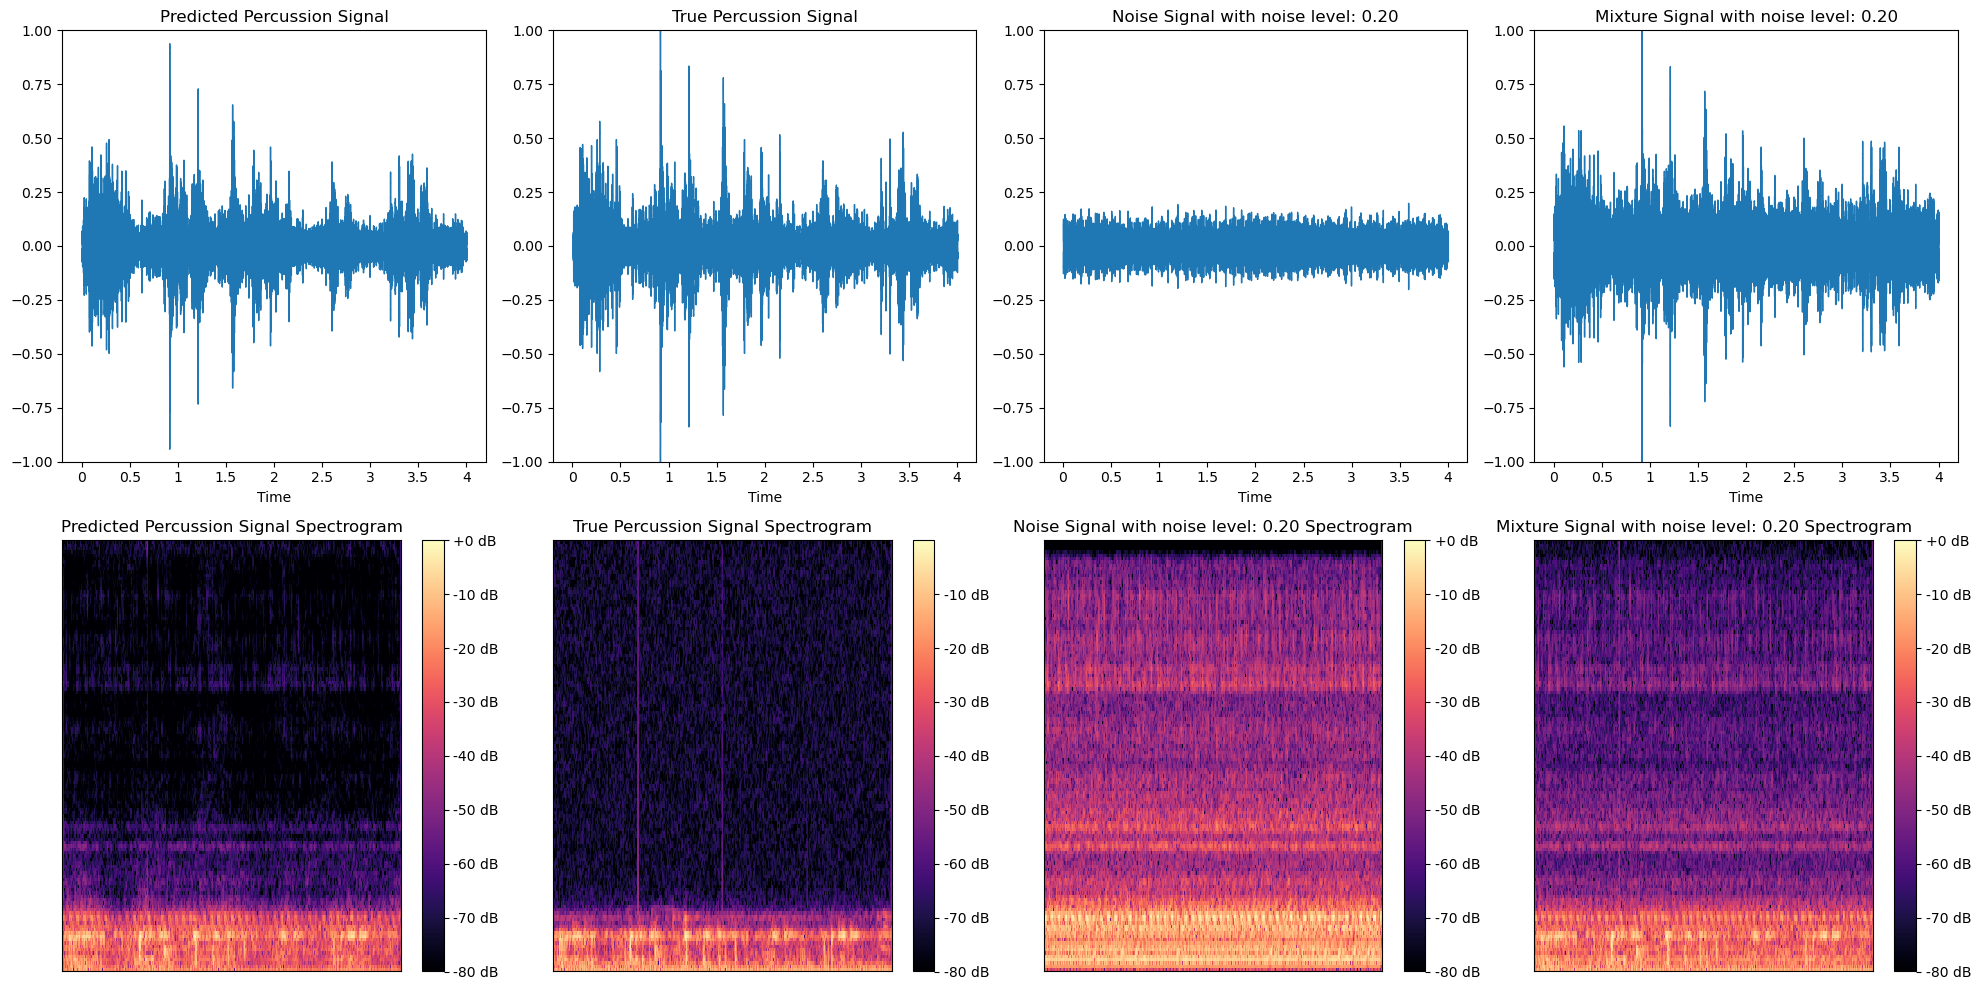

Predicted audio path: C:\Users\jejep\Desktop\STAGE\data\predicted_audio_engine_idling\data_2024_02_26-09_37_57_mix_106015-5-0-18_predicted.wav
True percussion audio path: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\data_2024_02_26-09_37_57.wav
Noise audio path: C:\Users\jejep\Desktop\STAGE\dataset\fold2\106015-5-0-18.wav
path of mix saved c:\Users\jejep\Desktop\STAGE\Projects\new\mixture_audio.wav


In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert audio to numpy
predicted_audio = data['predicted audio'][i].cpu().detach().numpy()
true_percussion_audio = data['percussion audio'][i].cpu().detach().numpy()
noise_audio = data['noise audio'][i].cpu().detach().numpy()
mixture_audio = data['mixture audio'][i].cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
titles = ["Predicted Percussion Signal", "True Percussion Signal", "Noise Signal with noise level: {:.2f}".format(
    data['noise level'][i]), "Mixture Signal with noise level: {:.2f}".format(data['noise level'][i])]
audios = [predicted_audio, true_percussion_audio, noise_audio, mixture_audio]

for j in range(4):
    plt.subplot(2, 4, j+1)
    plt.title(titles[j])
    librosa.display.waveshow(audios[j], sr=7812)
    plt.ylim([-1, 1])

# Plot the predicted and true percussion spectrograms
for j in range(4):
    plt.subplot(2, 4, j+5)
    plt.title(titles[j] + " Spectrogram")
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(
        audios[j], n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=7812, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# show the path of all the files
print(f'Predicted audio path: {data["path pred"][i]}')
print(f'True percussion audio path: {data["path true"][i]}')
print(f'Noise audio path: {data["path noise"][i]}')

# Save the mixture audio
sf.write("mixture_audio.wav", mixture_audio, 7812)
print(f'path of mix saved', os.path.abspath("mixture_audio.wav"))

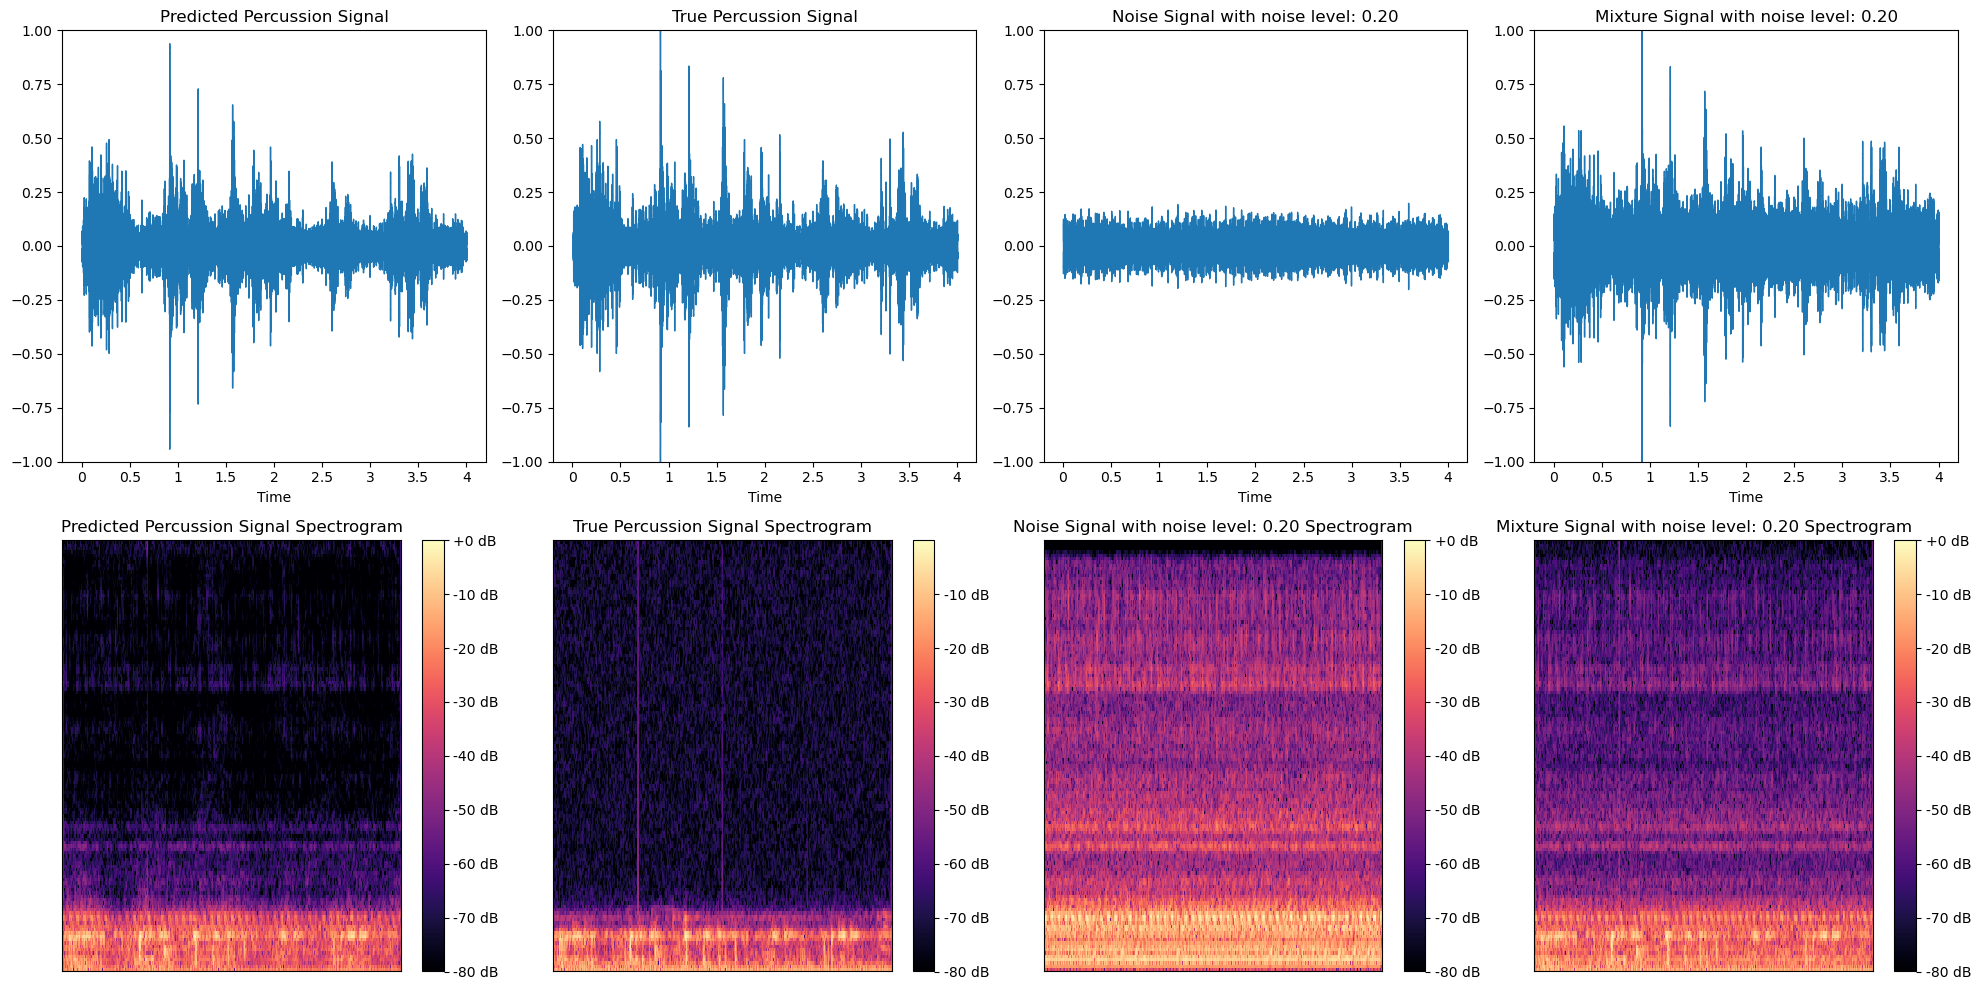

Predicted audio path: C:\Users\jejep\Desktop\STAGE\data\predicted_audio_engine_idling\data_2024_02_26-09_37_57_mix_106015-5-0-18_predicted.wav
True percussion audio path: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\data_2024_02_26-09_37_57.wav
Noise audio path: C:\Users\jejep\Desktop\STAGE\dataset\fold2\106015-5-0-18.wav
path of mix saved c:\Users\jejep\Desktop\STAGE\Projects\new\mixture_audio.wav


In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert audio to numpy
predicted_audio = data['predicted audio'][i].cpu().detach().numpy()
true_percussion_audio = data['percussion audio'][i].cpu().detach().numpy()
noise_audio = data['noise audio'][i].cpu().detach().numpy()
mixture_audio = data['mixture audio'][i].cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
titles = ["Predicted Percussion Signal", "True Percussion Signal", "Noise Signal with noise level: {:.2f}".format(
    data['noise level'][i]), "Mixture Signal with noise level: {:.2f}".format(data['noise level'][i])]
audios = [predicted_audio, true_percussion_audio, noise_audio, mixture_audio]

for j in range(4):
    plt.subplot(2, 4, j+1)
    plt.title(titles[j])
    librosa.display.waveshow(audios[j], sr=7812)
    plt.ylim([-1, 1])

# Plot the predicted and true percussion spectrograms
for j in range(4):
    plt.subplot(2, 4, j+5)
    plt.title(titles[j] + " Spectrogram")
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(
        audios[j], n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=7812, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# show the path of all the files
print(f'Predicted audio path: {data["path pred"][i]}')
print(f'True percussion audio path: {data["path true"][i]}')
print(f'Noise audio path: {data["path noise"][i]}')

# Save the mixture audio
sf.write("mixture_audio.wav", mixture_audio, 7812)
print(f'path of mix saved', os.path.abspath("mixture_audio.wav"))

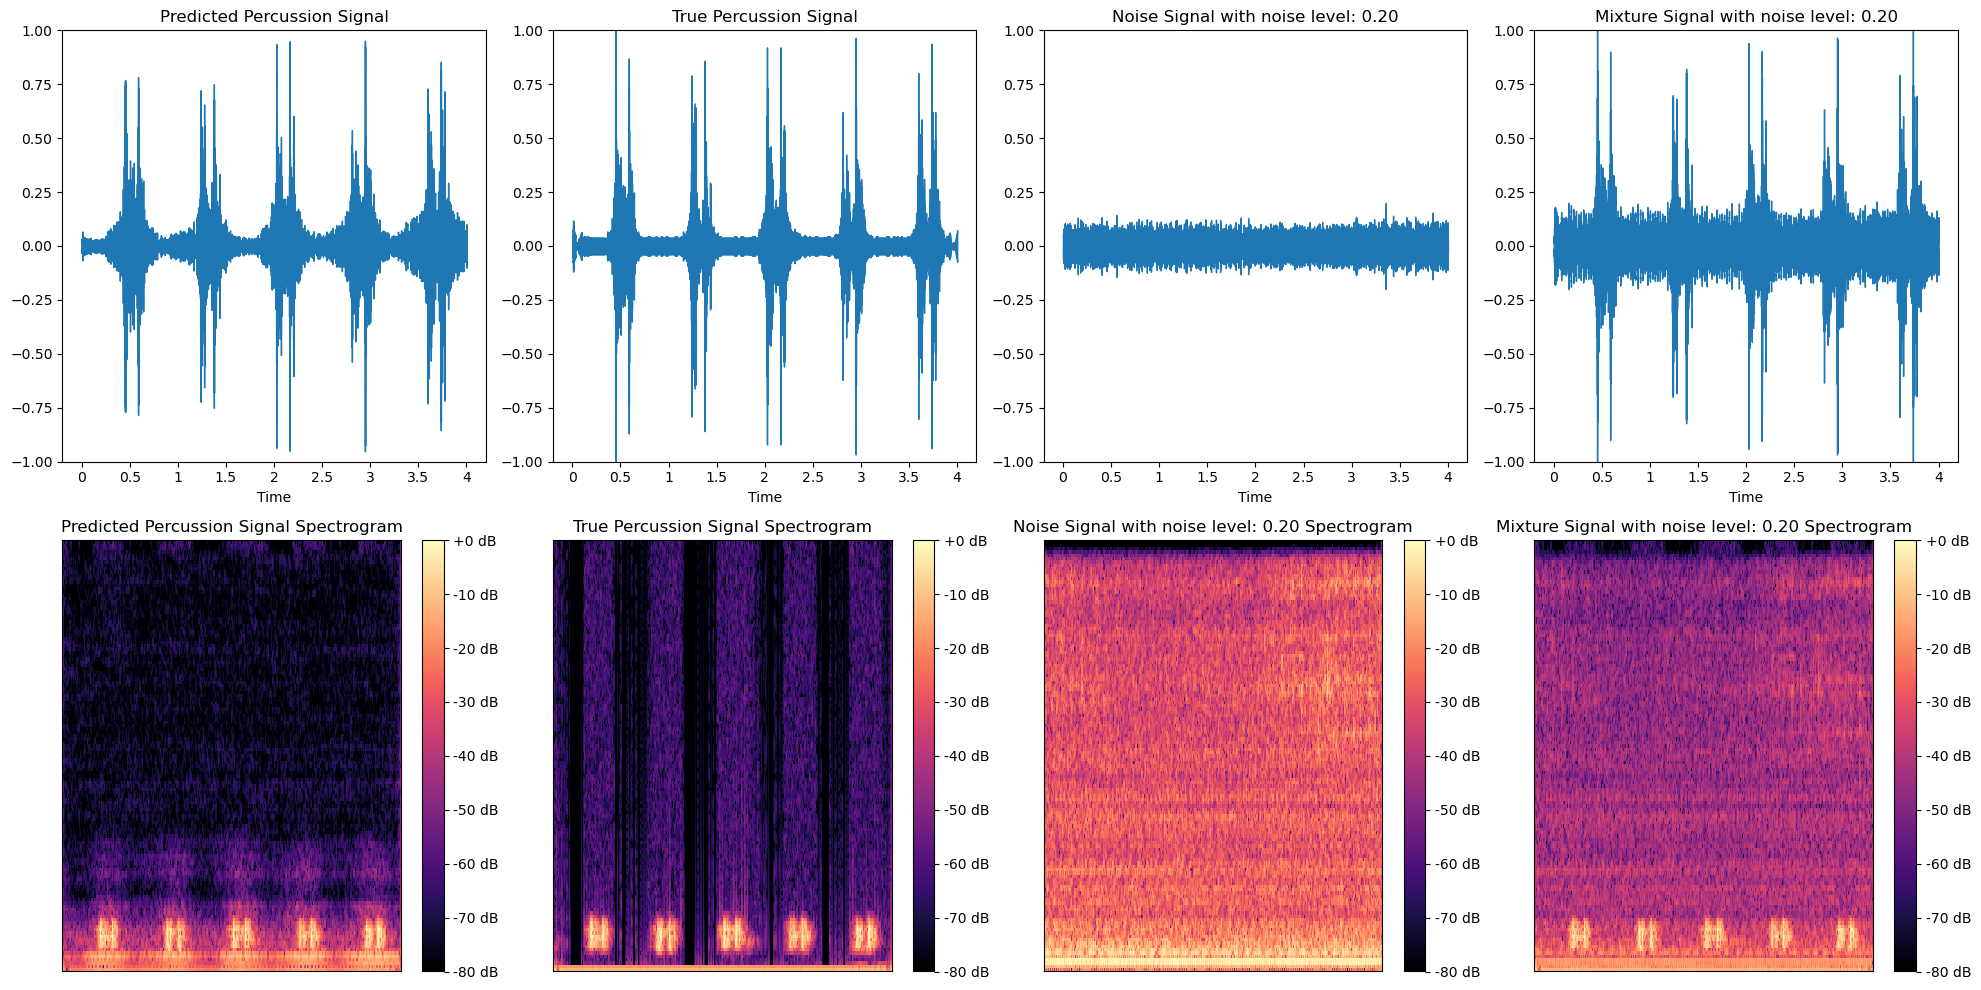

Predicted audio path: C:\Users\jejep\Desktop\STAGE\data\predicted_audio_engine_idling\hps_2024_02_21-09_16_57_mix_113216-5-0-0_predicted.wav
True percussion audio path: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\hps_2024_02_21-09_16_57.wav
Noise audio path: C:\Users\jejep\Desktop\STAGE\dataset\fold8\50668-5-5-1.wav
path of mix saved c:\Users\jejep\Desktop\STAGE\Projects\new\mixture_audio.wav


In [ ]:
# %%

# load the metadata file
df = pd.read_csv(os.path.join(DATASET_PREDICTED_AUDIO_PATH,
                              "metadata_pred_engine_idling.csv"))

# Create the dataset
test_separation_dataset = TestSeparationDataset(
    metadata_file=df, k=0.8)

# Create the data loader
test_separation_loader = DataLoader(
    test_separation_dataset, batch_size=16, shuffle=True)

# Plot the predicted and true percussion signals along their spectrograms
data = next(iter(test_separation_loader))

# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert audio to numpy
predicted_audio = data['predicted audio'][i].cpu().detach().numpy()
true_percussion_audio = data['percussion audio'][i].cpu().detach().numpy()
noise_audio = data['noise audio'][i].cpu().detach().numpy()
mixture_audio = data['mixture audio'][i].cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
titles = ["Predicted Percussion Signal", "True Percussion Signal", "Noise Signal with noise level: {:.2f}".format(
    data['noise level'][i]), "Mixture Signal with noise level: {:.2f}".format(data['noise level'][i])]
audios = [predicted_audio, true_percussion_audio, noise_audio, mixture_audio]

for j in range(4):
    plt.subplot(2, 4, j+1)
    plt.title(titles[j])
    librosa.display.waveshow(audios[j], sr=7812)
    plt.ylim([-1, 1])

# Plot the predicted and true percussion spectrograms
for j in range(4):
    plt.subplot(2, 4, j+5)
    plt.title(titles[j] + " Spectrogram")
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(
        audios[j], n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=7812, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# show the path of all the files
print(f'Predicted audio path: {data["path pred"][i]}')
print(f'True percussion audio path: {data["path true"][i]}')
print(f'Noise audio path: {data["path noise"][i]}')

# Save the mixture audio
sf.write("mixture_audio.wav", mixture_audio, 7812)
print(f'path of mix saved', os.path.abspath("mixture_audio.wav"))

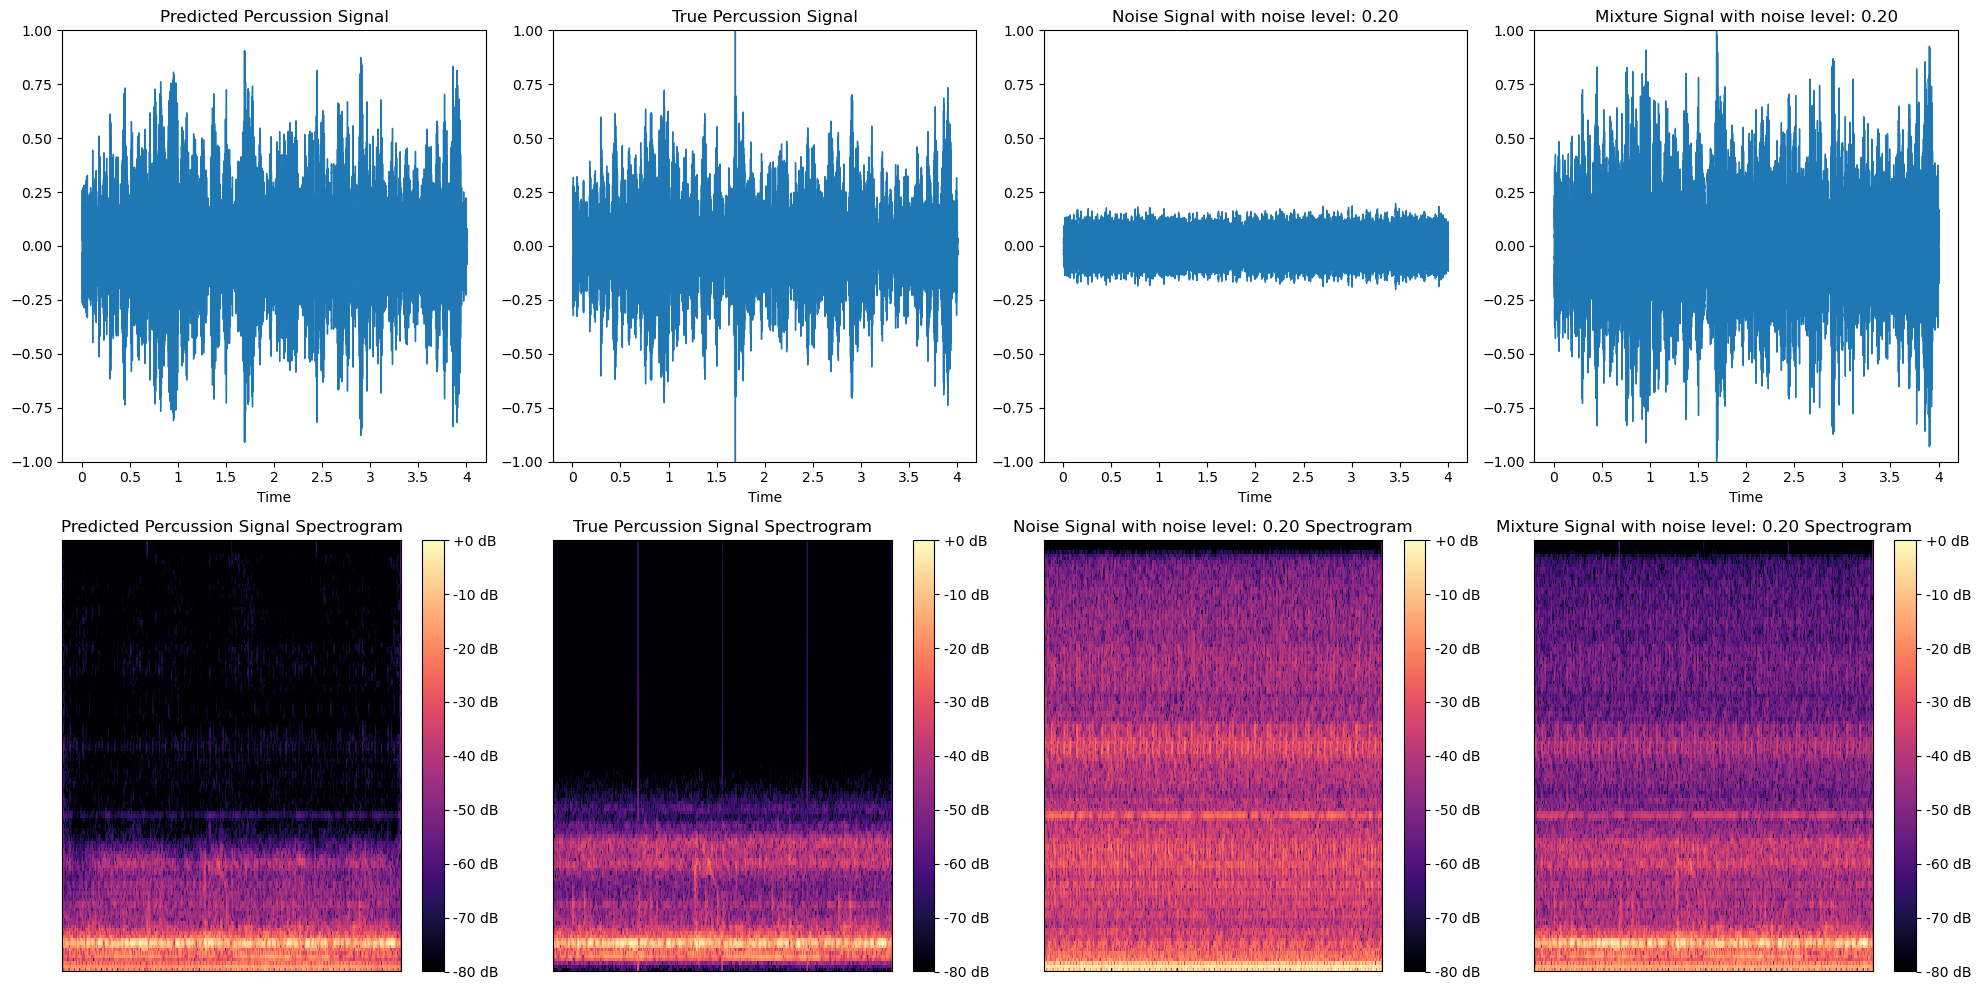

Predicted audio path: C:\Users\jejep\Desktop\STAGE\data\predicted_audio_engine_idling\hps_2024_03_13-16_08_30_mix_102857-5-0-29_predicted.wav
True percussion audio path: C:\Users\jejep\Desktop\STAGE\J.Palmilha\data\hps_2024_03_13-16_08_30.wav
Noise audio path: C:\Users\jejep\Desktop\STAGE\dataset\fold10\102857-5-0-3.wav
path of mix saved c:\Users\jejep\Desktop\STAGE\Projects\new\mixture_audio.wav


In [ ]:
# %%

# load the metadata file
df = pd.read_csv(os.path.join(DATASET_PREDICTED_AUDIO_PATH,
                              "metadata_pred_engine_idling.csv"))

# Create the dataset
test_separation_dataset = TestSeparationDataset(
    metadata_file=df, k=0.8)

# Create the data loader
test_separation_loader = DataLoader(
    test_separation_dataset, batch_size=16, shuffle=True)

# Plot the predicted and true percussion signals along their spectrograms
data = next(iter(test_separation_loader))

# randomly select an index
i = random.randint(0, len(data['predicted audio']) - 1)

# convert audio to numpy
predicted_audio = data['predicted audio'][i].cpu().detach().numpy()
true_percussion_audio = data['percussion audio'][i].cpu().detach().numpy()
noise_audio = data['noise audio'][i].cpu().detach().numpy()
mixture_audio = data['mixture audio'][i].cpu().detach().numpy()

# Plot the predicted and true percussion signals
plt.figure(figsize=(20, 10))
titles = ["Predicted Percussion Signal", "True Percussion Signal", "Noise Signal with noise level: {:.2f}".format(
    data['noise level'][i]), "Mixture Signal with noise level: {:.2f}".format(data['noise level'][i])]
audios = [predicted_audio, true_percussion_audio, noise_audio, mixture_audio]

for j in range(4):
    plt.subplot(2, 4, j+1)
    plt.title(titles[j])
    librosa.display.waveshow(audios[j], sr=7812)
    plt.ylim([-1, 1])

# Plot the predicted and true percussion spectrograms
for j in range(4):
    plt.subplot(2, 4, j+5)
    plt.title(titles[j] + " Spectrogram")
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(
        audios[j], n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=7812, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# show the path of all the files
print(f'Predicted audio path: {data["path pred"][i]}')
print(f'True percussion audio path: {data["path true"][i]}')
print(f'Noise audio path: {data["path noise"][i]}')

# Save the mixture audio
sf.write("mixture_audio.wav", mixture_audio, 7812)
print(f'path of mix saved', os.path.abspath("mixture_audio.wav"))

In [ ]:
metadata_noise

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
7353     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
7354     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
7355     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
7356     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
7357     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
7353        1          car_horn  
7354        1          car_horn  
7355        1          car_horn  
7356        1          car_horn  
7357        1          car_horn  

[7358 rows x 8 columns]